In [1]:
import numpy as np
from qiskit.quantum_info import random_statevector

# 2 Qubits

In [2]:
n_qubits = 2

### Generate "unkown" state you want to learn

In [3]:
psi = random_statevector(2**n_qubits).data.reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [4]:
measurement_strings = ["0", "1", "+", "-", "i", "-i"]

zero = np.array([1, 0]).reshape(-1, 1)
one = np.array([0, 1]).reshape(-1, 1)
plus = 1/np.sqrt(2) * np.array([1, 1]).reshape(-1, 1)
minus = 1/np.sqrt(2) * np.array([1, -1]).reshape(-1, 1)
i = 1/np.sqrt(2) * np.array([1, 1j]).reshape(-1, 1)
minus_i = 1/np.sqrt(2) * np.array([1, -1j]).reshape(-1, 1)

basis_states = [zero, one, plus, minus, i, minus_i]

### Create measurement projectors

In [5]:
# 2 qubits
measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
two_qubit_measurement_operators = []
for qubit_1_op in measurement_operators:
    for qubit_2_op in measurement_operators:
        two_qubit_measurement_operators.append(np.kron(qubit_1_op, qubit_2_op))

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [6]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in two_qubit_measurement_operators]

probabilities = get_probabilities(unkown_dm)
prob_dict = dict(zip(measurement_strings, probabilities))

### Create tunable state
Parameterization from: https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf

In [7]:
def get_parameterized_dm(t):
    """ t is a list of the tunable parameters """
    T = np.array([[t[0], 0, 0, 0],
                  [t[4] + 1j*t[5], t[1], 0, 0],
                  [t[10] + 1j*t[11], t[6] + 1j*t[7], t[2], 0],
                  [t[14] + 1j*t[15], t[12] + 1j*t[13], t[8] + 1j*t[9], t[3]]
                 
                 ])
    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [8]:
dm_parameters = np.random.uniform(low=-1, high=1, size=16)

In [9]:
parameterized_dm = get_parameterized_dm(dm_parameters)

### Test that DM is valid

In [10]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [11]:
def get_probabilites_from_parameters(t):
    parameterized_dm = get_parameterized_dm(t)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [12]:
from scipy.special import kl_div

def kl_divergence(true_probs, t):
    probs = get_probabilites_from_parameters(t)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, params)

In [13]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [14]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(found_params)

In [15]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

dm_fidelity(unkown_dm, found_dm)

0.9998838527234454

In [16]:
print(unkown_dm)

[[ 0.09130772-2.30029088e-19j  0.0508139 -1.14468075e-01j
   0.10340705+1.17430213e-01j -0.19734855+6.20991867e-02j]
 [ 0.0508139 +1.14468075e-01j  0.17178166+4.07372350e-18j
  -0.08966925+1.94987805e-01j -0.18767769-2.12847345e-01j]
 [ 0.10340705-1.17430213e-01j -0.08966925-1.94987805e-01j
   0.26813584+3.69700825e-18j -0.14363418+3.24136606e-01j]
 [-0.19734855-6.20991867e-02j -0.18767769+2.12847345e-01j
  -0.14363418-3.24136606e-01j  0.46877478-4.66571871e-19j]]


In [17]:
print(found_dm)

[[ 0.09135996-2.31023715e-18j  0.05079917-1.14458124e-01j
   0.10336367+1.17392548e-01j -0.197302  +6.20781450e-02j]
 [ 0.05079917+1.14458124e-01j  0.17175788+3.52937358e-18j
  -0.08965017+1.94930970e-01j -0.18763551-2.12829736e-01j]
 [ 0.10336367-1.17392548e-01j -0.08965017-1.94930970e-01j
   0.26809979-2.75301351e-18j -0.14362355+3.24111654e-01j]
 [-0.197302  -6.20781450e-02j -0.18763551+2.12829736e-01j
  -0.14362355-3.24111654e-01j  0.46878238+1.53387708e-18j]]


### Plot Density Matrices

In [18]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

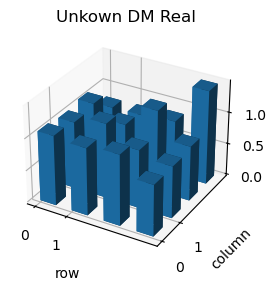

[[1.09130772 1.0508139  1.10340705 0.80265145]
 [1.0508139  1.17178166 0.91033075 0.81232231]
 [1.10340705 0.91033075 1.26813584 0.85636582]
 [0.80265145 0.81232231 0.85636582 1.46877478]]


In [20]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

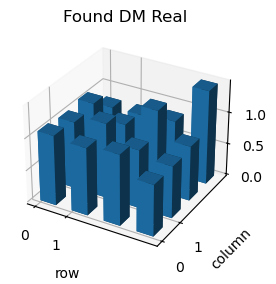

[[1.09135996 1.05079917 1.10336367 0.802698  ]
 [1.05079917 1.17175788 0.91034983 0.81236449]
 [1.10336367 0.91034983 1.26809979 0.85637645]
 [0.802698   0.81236449 0.85637645 1.46878238]]


In [21]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

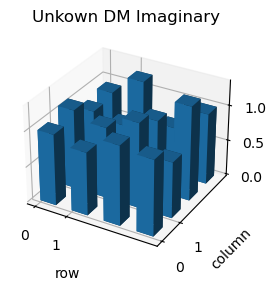

[[1.         0.88553193 1.11743021 1.06209919]
 [1.11446807 1.         1.1949878  0.78715265]
 [0.88256979 0.8050122  1.         1.32413661]
 [0.93790081 1.21284735 0.67586339 1.        ]]


In [22]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

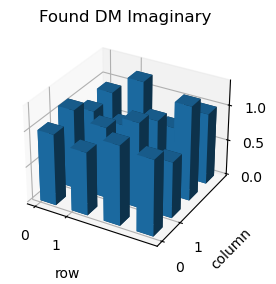

[[1.         0.88554188 1.11739255 1.06207815]
 [1.11445812 1.         1.19493097 0.78717026]
 [0.88260745 0.80506903 1.         1.32411165]
 [0.93792185 1.21282974 0.67588835 1.        ]]


In [23]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)

## Reconstruct state vector from the density matrix 

In [24]:
def density_matrix_to_state_vector(rho):
    """Extracts a state vector from a pure-state density matrix."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Find the eigenvector corresponding to eigenvalue ~1
    idx = np.argmax(eigenvalues)  # The largest eigenvalue (should be ~1 for a pure state)
    
    # Extract the corresponding eigenvector
    state_vector = eigenvectors[:, idx]

    # Normalize the state vector
    state_vector = state_vector / np.linalg.norm(state_vector)

    return state_vector

#### original psi

In [25]:
print("original psi", psi)

prob_0 = np.abs(psi[0])**2
prob_1 = np.abs(psi[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original psi [[ 0.29045666-0.08332259j]
 [ 0.26610028+0.31776139j]
 [ 0.22178493-0.46791803j]
 [-0.68444883-0.0174523j ]]
prob_0 [0.09130772]
prob_1 [0.17178166]


#### original psi from density matrix, testing that it matches psi

In [27]:
original_psi_from_dm = density_matrix_to_state_vector(unkown_dm)
print("original_psi_from_dm", original_psi_from_dm)

prob_0 = np.abs(original_psi_from_dm[0])**2
prob_1 = np.abs(original_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original_psi_from_dm [ 0.30217168+0.j          0.16816234+0.37881801j  0.34221291-0.38862084j
 -0.65310074-0.20550962j]
prob_0 0.09130772436764771
prob_1 0.17178165776401857


#### statevector from reconstructed dm

In [28]:
found_psi_from_dm = density_matrix_to_state_vector(found_dm)
print("found_psi_from_dm", found_psi_from_dm)
prob_0 = np.abs(found_psi_from_dm[0])**2
prob_1 = np.abs(found_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

found_psi_from_dm [ 0.3021521 +0.j         0.16813925+0.3788006j  0.34219136-0.3886145j
 -0.65314328-0.2055021j]
prob_0 0.09129589082744499
prob_1 0.1717607001107039


### State vector fidelity

In [29]:
def statevector_fidelity(psi, phi):
    """Computes the fidelity between two state vectors."""
    psi = np.array(psi, dtype=complex)
    phi = np.array(phi, dtype=complex)
    
    # Normalize the state vectors
    psi /= np.linalg.norm(psi)
    phi /= np.linalg.norm(phi)
    
    # Compute fidelity
    fidelity = np.abs(np.vdot(psi, phi)) ** 2
    return fidelity

In [30]:
statevector_fidelity(psi, found_psi_from_dm)

0.9999999966065163